# Introdução a Séries Temporais

Tutorial for improve skills: 'Séries Temporais com python/pandas/statsmodels - Parte 01' (ORMaster) by Marcus Mariano

**For more information about Marcus Mariano: [Web site](https://marcusmariano.github.io/mmariano/)**  

**Séries Temporais com python/pandas/statsmodels - Parte 01 [ORMaster.](https://www.youtube.com/playlist?list=PL5fQ3JoS0SZscDaHgXahtx632NMnq5RR-)** 

**ronaldolagepessoa: [GitHub.](https://github.com/ronaldolagepessoa/timeseries)**


## Métodos preditivos

Previsões de séries temporais é um tópico com muitas aplicações possíveis, tais como previsão de preço de ativos, previsão do tempo, planejamento de negócios, alocação de recursos e muitos outros.

Um séries temporais é usualmente  modelada sob um processo estocástico $Y(t)$, i.e., uma sequência de variáveis aleatórias. Em uma previsão, estamos no momento $t$ e temos interesse de estimar $Y(t+1)$, usando somente as informações disponíveis até o momento $t$.

In [1]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", color_codes=True)
%matplotlib inline

In [37]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Set parameters

In [2]:
N_THREADS = 6 # threads cnt for lgbm and linear models
N_FOLDS = 10 # folds cnt for AutoML
N_JOBS = -1 # -1 means using all processors
SEED = 0 # fixed random state for various reasons
TEST_SIZE = 0.3 # Test size for metric check
VERBOSE = 1
EPOCHS = 50
TIMEOUT = 600 # Time in seconds for automl run, 600 seconds = 10 minutes
RAM = 16 #  Number of RAM limit
CPU_LIMIT = 16 # Number of CPU limit
TARGET_NAME = 'CHURN'

In [3]:
Path = ""

data = pd.read_csv(Path+"data/shampoo.csv")
print(data.shape)
data.head()

(36, 2)


,Month,Sales
0,2000-01,266.0
1,2000-02,145.9
2,2000-03,183.1
3,2000-04,119.3
4,2000-05,180.3


## Modelo Naive

O modelo _Naive_ é o exemplo mais básico e "inocente" de preditor para uma série temporal. A idéia do modelo é a de que o valor previsto para o período atual $t$ seja igual ao valor do período $t-1$. Para demonstrar a aplicação do modelo _Naive_, utilizaremos os dados contidos no arquivo ```shampoo.csv```, representando as vendas mensais de shampoo.

In [41]:
train = data.copy()

In [42]:

train.Month = pd.to_datetime(train.Month)
train.set_index('Month', inplace=True)

Para avaliar a qualidade do modelo, faremos a previsão para toda a série temporal utilizando o comando ```Series.shift()```. Criaremos uma nova coluna chamada ```Sales_prediction``` como sendo o deslocamento de um período da coluna ```Sales```.

In [43]:
train['naive_prediction'] = train.Sales.shift(1)
train.head()

,Sales,naive_prediction
Month,,
2000-01-01,266.0,NaN
2000-02-01,145.9,266.0
2000-03-01,183.1,145.9
2000-04-01,119.3,183.1
2000-05-01,180.3,119.3


Plotando as duas séries, é possível observar o comportamento do modelo.

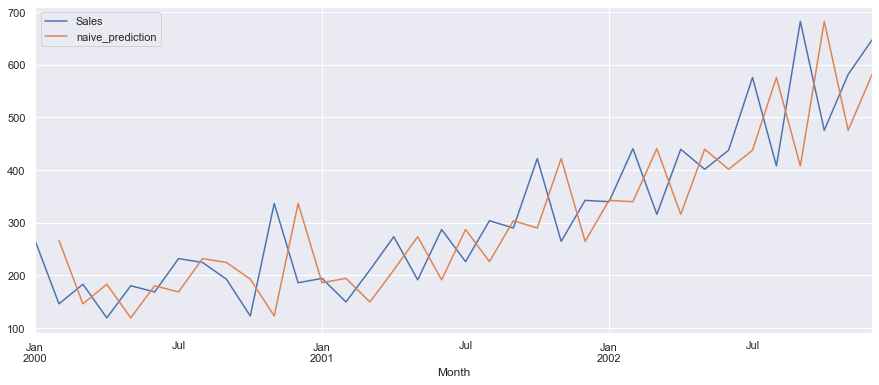

In [24]:
train.plot(figsize=(15, 6));

### Validação

Faremos a validação do modelo _Naive_ calculando o erro médio quadrático entre as previsões e os valores observados. Para tanto, faremos o cálculo da diferença quadrática entre a coluna ```Sales``` e a coluna ```naive_prediction```. Guardaremos a ```Series``` gerada em uma variável chamada ```errors```. Para calcular a média do erro, utilizamos o comando ```Series.mean()```.

In [44]:
((train.Sales - train.naive_prediction) ** 2).mean()

11715.388285714287

O modelo _Naive_ é utilizado como referência para modelos mais sofisticados. A idéia é que modelos de previsão possuam erro médio quadrático menor que o modelo _Naive_. Caso contrário, temos um modelo extremamente ineficaz.

## Modelo AutoRegressivo (AR)

Em modelos de regressão múltipla, fazemos a previsão da variável de interesse utilizando a combinação linear das variáveis preditoras. Em um modelo autoregressivo, fazemos a previsão da variável de interesse utilizando a combinação linear dos valores passados da mesma variável. O termo autoregressivo indica que o processo é definido como um modelo de regressão de uma variável por ela mesma.


Assim, um modelo autoregressivo de ordem $p$ pode ser escrito como

$$y_t = c + \beta_1y_{t-1} + \beta_2y_{t-2} + \cdots + \beta_p y_{t - p} + \epsilon_t$$

onde $\epsilon_t$ é o ruído branco. Nos referimos a um modelo AR($p$) como um modelo autoregressivo de ordem $p$.

Faremos a implementação de um modelo AR(1) para o exemplo do shampoo. Para tanto, criaremos um novo ```DataFrame``` chamado ```df1``` que contém a coluna ```Sales``` e a coluna ```x1```. Onde ```x1``` representa o valor da venda com _lag_ de 1 período.

In [45]:
train1 = train.drop('naive_prediction', axis=1)
train1['x1'] = train.Sales.shift(1)
train1.dropna(axis=0, inplace=True)
train1.head()

,Sales,x1
Month,,
2000-02-01,145.9,266.0
2000-03-01,183.1,145.9
2000-04-01,119.3,183.1
2000-05-01,180.3,119.3
2000-06-01,168.5,180.3


Trataremos o modelo AR(1) como uma regressão linear simples, onde ```x1``` é a variável independente e ```Sales``` é a variável dependente. Utilizando a classe ```LinearRegression``` do pacote sklearn, podemos criar o modelo de regressão que equivale ao modelo autoregressivo AR(1).

In [46]:
from sklearn.linear_model import LinearRegression

X = train1.x1.values
y = train1.Sales.values

l_reg = LinearRegression().fit(X.reshape(-1, 1), y)
preds = l_reg.predict(X.reshape(-1, 1))
errors = (y - preds) ** 2
errors.mean()

10668.73613429366

Rodando o modelo de regressão para o AR(1) obtemos $r^2 = 10668.73$, valor inferior ao obtido com o modelo _Naive_. Abaixo, temos a representação visual do modelo de regressão linear.

Text(0, 0.5, 'Sales')

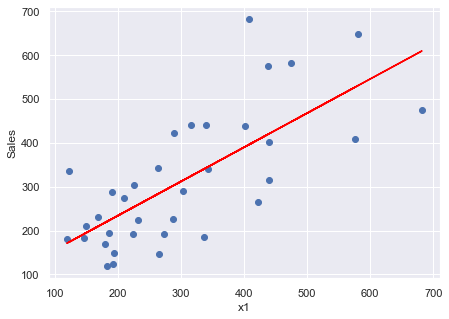

In [47]:
fig = plt.subplots(figsize=(7, 5))

plt.scatter(X, y)
plt.plot(X, l_reg.predict(X.reshape(-1, 1)), color='red')
plt.xlabel('x1')
plt.ylabel('Sales')

Para visualizar o modelo na forma de uma série temporal criaremos uma nova coluna no ```DataFrame``` ```df1``` chamada ```ar_1```.

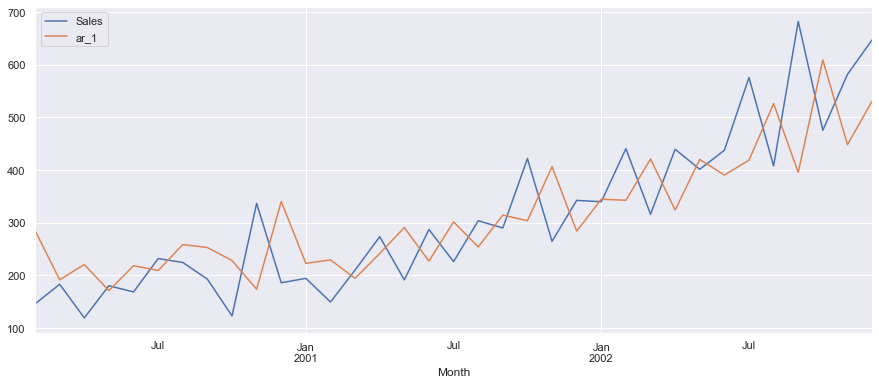

In [48]:
train1['ar_1'] = l_reg.predict(X.reshape(-1, 1))
train1[['Sales', 'ar_1']].plot(figsize=(15, 6));

Faremos, agora, a aplicação do modelo de regressão para AR(2). Para tanto, acrescentaremos a coluna denominada ```x2```, representando o _lag_ de 2 períodos. Nesse caso, temos um modelo de regressão linear múltipla com ```x1``` e ```x2``` como variáveis independentes e ```Sales``` como variável dependente.

In [49]:
train1['x2'] = train.Sales.shift(2)
train1.dropna(axis=0, inplace=True)
train1.head()

,Sales,x1,ar_1,x2
Month,,,,
2000-03-01,183.1,145.9,191.610723,266.0
2000-04-01,119.3,183.1,220.566317,145.9
2000-05-01,180.3,119.3,170.905917,183.1
2000-06-01,168.5,180.3,218.386864,119.3
2000-07-01,231.8,168.5,209.202025,180.3


In [50]:
X = train1[['x1', 'x2']]
y = train1.Sales.values

l_reg2 = LinearRegression().fit(X, y)
predictions = l_reg2.predict(X)
errors = (y - predictions) ** 2
errors.mean()

5154.048667052168

O novo modelo possui $r^2=5154.04$

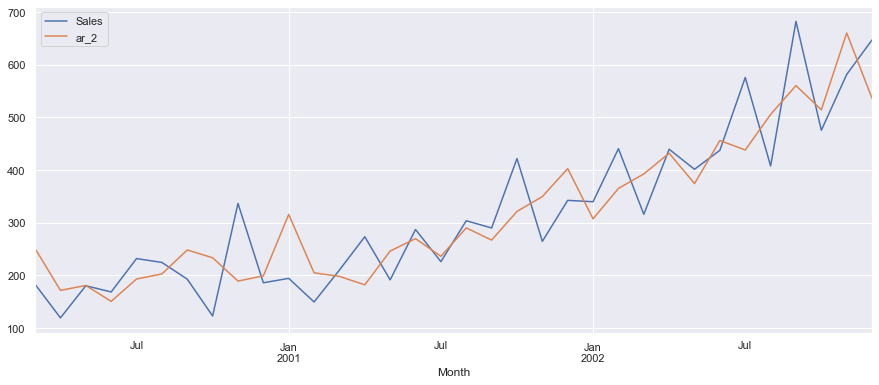

In [51]:
train1['ar_2'] = l_reg2.predict(X)
train1[['Sales', 'ar_2']].plot(figsize=(15, 6));

### Utilizando o pacote statsmodels

Para facilitar o uso de modelos autoregressivos, utilizaremos o pacote ```statsmodels```. O modelo autoregressivo encontra-se no subpacote ```tsa.ar_model```. Para importar utilizamos o comando ```from statsmodels.tsa.ar_model import AR```. Para criar o modelo, utilizamos o comando ```AR(Series).fit(p)```, onde $p$ é o número de períodos passados (_lag_) considerados no modelo.

Faremos a criação do modelo AR(2) para comparar com o resultado gerado anteriormente. Chamaremos o modelo criado de ```ar_2```.

In [52]:
from statsmodels.tsa.ar_model import AR

ar_2 = AR(train["Sales"], freq='MS').fit(2)

Utilizando o atributo ```resid```, obtemos os erros residuais das previsões de cada período da série na forma de um objeto do tipo ```Series``` do pandas. Podemos utilizar essa informação para calcular o erro quadrático do modelo elevando a ```Series``` contendo os erros residuais por 2 e calculando a média do resultado.

In [53]:
(ar_2.resid ** 2).mean()

5154.048667052169

O resultado obtido é o mesmo do modelo criado a partir do modelo de regressão linear. 

Para analisar de forma descritiva os erros do modelo, temos a possibilidade de utilizar o comando ```Series.describe()```.

In [54]:
ar_2.resid.describe()

count    3.400000e+01
mean    -8.359326e-16
std      7.287134e+01
min     -1.213016e+02
25%     -5.535156e+01
50%      3.538038e+00
75%      3.114397e+01
max      1.473753e+02
dtype: float64

A média dos erros está muito próxima de zero, indicando que não existe uma proporção maior de erros pra cima ou pra baixo. O desvio padrão nos dá uma noção de variabilidade do erro e os quartis mostram a distribuição do mesmo.

Pra facilitar a análise da distribuição dos erros, podemos utilizar gráficos do tipo histograma e boxplot. Geramos o boxplot dos erros utilizando o comando ```Series.plot(kind='box')```.

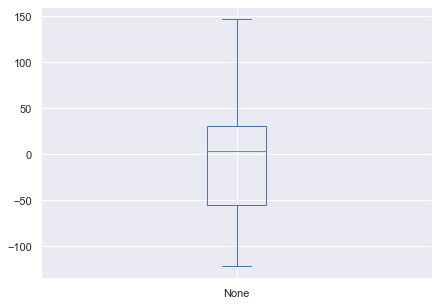

In [56]:
fig = plt.subplots(figsize=(7, 5))

ar_2.resid.plot(kind='box');

Analisando o gráfico percebemos que a mediana (representada pela linha verde) está próxima do valor zero (com valor igual a 3.53). A posição da mediana na "caixa" do boxplot indica que os erros estão mais dispersos abaixo da mediana.

A análise pode ser finalizada com o uso do histograma dos erros. Para criar o histograma, utilizamos o comando ```Series.hist()```.

<AxesSubplot:>

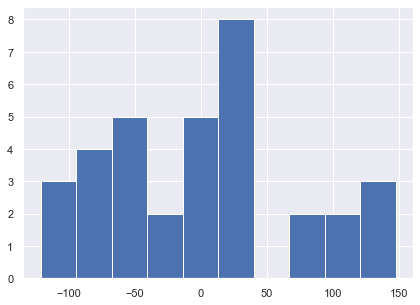

In [57]:
fig = plt.subplots(figsize=(7, 5))

ar_2.resid.hist()

Analisando a distribuição de frequência do erro, observamos que, apesar da média está concentrada no zero, os erros abaixo da média estão mais distribuidos do que os erros acima da média.

Para finalizar, analisaremos o modelo AR(3).

In [58]:
ar_3 = AR(train["Sales"], freq='MS').fit(3)
(ar_3.resid ** 2).mean()

4389.270411689365

Para prever um intervalo de períodos específico, faremos a configuração dos parâmetros ```start``` e ```end``` do comando ```predict()```. No exemplo, temos os valores de vendas até o período '2002-12'. Faremos a previsão de vendas para o período seguinte fazendo ```start='2003-01'``` e ```end='2003-01'```. Criaremos uma variável chamada ```forecast``` para guardar a ```Series``` resultante da previsão e plotaremos o resultado utilizando um gráfico ```plt.scatter()```.

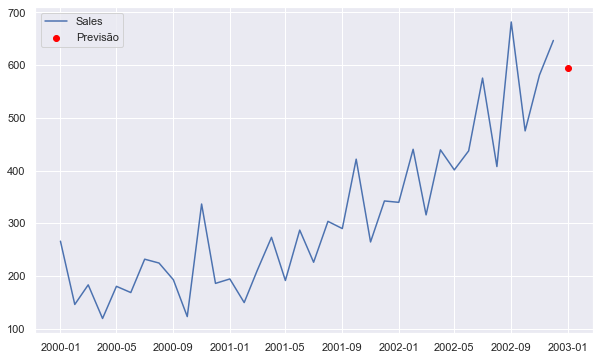

In [59]:
plt.figure(figsize=(10, 6))

plt.plot(train.Sales)
forecast = ar_3.predict(start='2003-01', end='2003-01')
plt.scatter(forecast.index, forecast.values, color='red')
plt.legend(['Sales', 'Previsão'])

Para séries temporais, estamos interessados na previsão somente do próximo período. No exemplo, previsões para o período '2003-02' utilizariam a previsão feita no período '2003-01' como _input_, reduzindo drásticamente a qualidade da previsão.

In [60]:
ar_3.predict(start='2003-01-01', end='2003-02-01')

2003-01-01    595.230272
2003-02-01    686.891063
Freq: MS, dtype: float64